
# Training Artificial Neural Networks with MNIST Dataset


# Introduction
In this tutorial, you will:
* Learn how Artifical neurons are implemented as in a feed-forward neural network.


If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`


In [17]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. Setting up the Static MNIST Dataset

In [18]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [19]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [20]:
print('Samples in test set:',len(mnist_test))
print('Samples in train set:',len(mnist_train))

Samples in test set: 10000
Samples in train set: 60000


If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [21]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [22]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 2. Define the Network

In [23]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10


In [24]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.relu2 = nn.ReLU()

    def forward(self, x):

        lin1 = self.fc1(x)
        lin1_act = self.relu1(lin1)
        lin2 = self.fc2(lin1_act)
        lin2_act = self.relu2(lin2)

        return lin2_act

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `relu1` apply relu activation;
* `fc2` applies a linear transformation to the output signal of `relu1`;
* `relu2` apply another relu activation.

# 3. Training the ANN

## 3.1 Accuracy Metric


In [25]:


def print_batch_accuracy(data, targets, train=False):
    output = net(data.view(batch_size, -1))
    pred = np.argmax(output.detach().cpu().numpy(), axis=1)
    acc = np.mean((targets.detach().cpu().numpy() == pred))

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 3.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [26]:
loss = nn.CrossEntropyLoss()

## 3.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$. This value is the same we used with SNN code implementation.

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 3.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [28]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [29]:
data.shape

torch.Size([128, 1, 28, 28])

In [30]:
data.view(batch_size, -1).shape

torch.Size([128, 784])

Flatten the input data to a vector of size $784$ and pass it into the network.

In [31]:
output = net(data.view(batch_size, -1))
print(output.size())

torch.Size([128, 10])


In [32]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# # sum loss at every step
# for step in range(num_steps):
loss_val = loss(output, targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 2.301


The loss is quite large, and the accuracy is also bad (it should be roughly around 10%) as the network is untrained:

In [33]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 12.50%


A single weight update is applied to the network as follows:

In [34]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [35]:
# calculate new network outputs using the same data
output = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
loss_val = loss(output, targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 2.231
Train set accuracy for a single minibatch: 50.00%


After only one iteration, the loss should have decreased and accuracy should have increased.

## 3.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [36]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        output = net(data.view(batch_size, -1))

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(output, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            output = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            test_loss = loss(output, test_targets)
            test_loss_hist.append(test_loss.item())

            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 2.26
Test Set Loss: 2.24
Train set accuracy for a single minibatch: 45.31%
Test set accuracy for a single minibatch: 33.59%


Epoch 0, Iteration 50
Train Set Loss: 1.25
Test Set Loss: 1.28
Train set accuracy for a single minibatch: 57.81%
Test set accuracy for a single minibatch: 53.91%


Epoch 0, Iteration 100
Train Set Loss: 1.16
Test Set Loss: 1.16
Train set accuracy for a single minibatch: 57.03%
Test set accuracy for a single minibatch: 56.25%


Epoch 0, Iteration 150
Train Set Loss: 1.21
Test Set Loss: 1.20
Train set accuracy for a single minibatch: 55.47%
Test set accuracy for a single minibatch: 55.47%


Epoch 0, Iteration 200
Train Set Loss: 1.10
Test Set Loss: 1.13
Train set accuracy for a single minibatch: 58.59%
Test set accuracy for a single minibatch: 56.25%


Epoch 0, Iteration 250
Train Set Loss: 1.24
Test Set Loss: 1.18
Train set accuracy for a single minibatch: 51.56%
Test set accuracy for a single minibatch: 53.91%


Epoch 0, Iter

# 8. Results
## 8.1 Plot Training/Test Loss

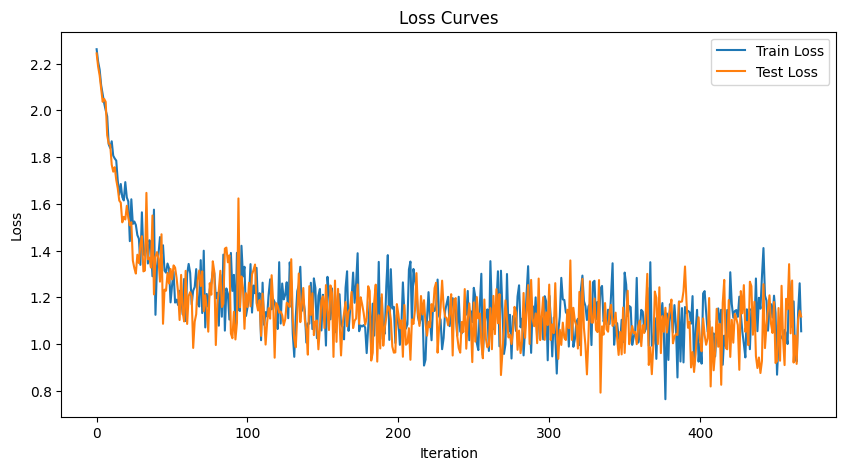

In [37]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [38]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)



with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    output = net(data.view(data.size(0), -1))
    pred = np.argmax(output.detach().cpu().numpy(), axis=1)
    acc = np.sum((targets.detach().cpu().numpy() == pred))


    total += targets.size(0)
    correct += acc

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 5810/10000
Test Set Accuracy: 58.10%


In [39]:
print(pred)
print(targets.detach().cpu().numpy())

[0 5 1 0 2 8 0 2 8 5 0 1 0 0 0 1]
[0 5 1 0 7 8 9 2 8 5 3 1 7 9 3 1]


Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance.